# E5-2. Spectrogram classification 모델(Conv2D) 구현
### A-1. 데이터 준비 및 분석
#### 데이터 다운 (1.6G 대용량)
- mkdir -p ~/aiffel/speech_recognition/data
- mkdir -p ~/aiffel/speech_recognition/models
- -P ~/aiffel/speech_recognition/data
- wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz 

#### Spectrogram  
- waveform은 음성 데이터를 1차원 시계열 데이터로 해석하는 방법
- waveform은 많은 음원의 파형이 합성된 복합파
- 좀 더 뚜렷하게 다양한 파형들을 주파수 대역별로 나누어 해석할 수 있는 방법이 Spectrogram  
  
1. 푸리에 변환 (Fourier transform)  
- 푸리에 변환: $A_k = \frac{1}{T}\int^{\frac{T}{2}}_{-\frac{T}{2}}f(t)\exp(-2\pi i\frac{k}{T}t)dt$
  
<img src = "https://user-images.githubusercontent.com/76797423/206323017-b6e66fd7-fff3-48b3-bcd6-ed86c38603bb.png">  
  
2. 오일러 공식
- 푸리에 변환은 입력 signal에 상관 없이 sin, cos과 같은 주기함수들의 합으로 항상 분해가 가능
- cos과 sin은 주기와 주파수를 가지는 주기함수
- 오일러 공식 : $e^{i\theta}=\cos\theta+\sin\theta$
- $\exp(2\pi i\frac{k}{T}t)=\cos(2\pi\frac{k}{T})+j\sin(2\pi\frac{k}{T})$  
  
<img src = "https://user-images.githubusercontent.com/76797423/206325362-6f66bb47-884e-46f9-be5e-1735bfecd4aa.png">  
  
- 푸리에 변환이 끝나면 실수부와 허수부를 가지는 복소수가 얻어지는데, 
- 복소수의 절댓값은 Spectrum magnitude(주파수의 강도)라고 부르며, angle은 phase spectrum(주파수의 위상)이라고 부름  
  
<img src = "https://user-images.githubusercontent.com/76797423/206325577-60493846-e129-4efd-8dc5-9af54011062a.png">  
  
3. STFT(Short Time Fourier Transform)
- FFT(Fast Fourier Transform)는 시간의 흐름에 따라 신호의 주파수가 변했을 때, 어느 시간대에 주파수가 변하는지 모르기 때문에 나온 대안이 STFT
- STFT는 시간의 길이를 나누어 푸리에 변환 적용
- $X(l,k)=\sum^{N-1}_{n=0}\omega(n)x(n+lH)\exp^{-\frac{2kn\pi}{N}}$
    - N = FFT size, Window를 얼마나 많은 주파수 밴드로 나누는 가를 의미
    - Duration = sampling rate / window, 이 값은 신호주기보다 5배 이상 길게 잡아야 함 (즉, T(window)=5T(signal))
        - ex) 440Hz의 window size = 5(1/440)
    - $\omega(n)$ = window 함수, 일반적으로는 hann window 가 많이 쓰임
    - n = window size, window 함수에 들어가는 sample의 양으로 n이 작을수록 low-frequency resolution, high-time resolution을 갖게 되고, n이 길어지면 high-frequency, low-time resolution을 가짐
    - H = hop size, window가 겹치는 사이즈이며, 일반적으로 1/4정도를 겹치게 함  
      
    <img src = "https://user-images.githubusercontent.com/76797423/206326570-59db89ae-a877-42f1-9117-6633e07ef3b1.png">  
  
4. Spectrogram 이란?
- wav 데이터를 해석하는 방법 중 하나
- 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는 지를 보여줌
- STFT를 이용하여 Spectrogram으로 표현

In [1]:
#### 1. 데이터 로드 ####################################################################################
import numpy as np
import os

#data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load('speech_wav_8000.npz')
for i in speech_data:
    print(i)

data = speech_data["wav_vals"]
label = speech_data["label_vals"]

# 1초 길이의 오디오 데이터 50620개, 1개 당 8000가지의 sample data 보유
print("Wave data shape : ", speech_data["wav_vals"].shape) # 8000*1사이즈(데이터의 feature) 데이터 50620개 = 50620*8000 행렬
print("Label data shape : ", speech_data["label_vals"].shape) # 데이터 개수만큼 라벨(정답지) 존재 = 50620*1 행렬

wav_vals
label_vals
Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [2]:
#### 2. 데이터 확인 ####################################################################################
import IPython.display as ipd
import random

# 데이터 50260개 중 랜덤 추출 : 라벨과 맞는지 확인
rand = random.randint(0, len(speech_data["wav_vals"]))
print("random number : ", rand)
data_sample = speech_data["wav_vals"][rand]  # 웨이브 데이터??
label_sample = speech_data["label_vals"][rand]
print("Wave data shape : ", data_sample.shape)
print("label data shape : ", label_sample.shape)
print("label : ", label_sample)
print("wave data : ")
## rate = data의 feature 수 (1초동안 재생되는 샘플 수)
ipd.Audio(data_sample, rate=data_sample.shape[0]) 

random number :  34535
Wave data shape :  (8000,)
label data shape :  (1,)
label :  ['right']
wave data : 


### A-2. Spectrogram(2D 데이터)으로 변환 후, 입력 데이터에 저장
  
* wav 데이터를 해석하는 방법 중 하나로, 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는 지를 보여줌  
* X축은 시간, Y축은 주파수  
* 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현  
* wav 데이터가 단위 시간만큼 Short Time Fourier Transform(STFT)을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram을 완성
- FFT 라이브러리 설치 : `pip install librosa` 
  
- 참고 : FFT는 시간흐름에 관한 정보가 사라지기 떄문에, 이를 보완하기 위해 나온 개념이 STFT

In [3]:
#### 3. 웨이브->스펙으로 바꾸는 함수 정의 ##################################################################
## 1차원 웨이브 데이터를 2차원 스펙트로그램 데이터로 바꿔서 분류
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

## data_sample = speech_data["wav_vals"][rand] : 위에서 뽑았던 sample data
## 웨이브 데이터를 스펙트로그램으로 변환 (1-dim data -> 2-dim data)
spec = wav2spec(data_sample).astype(np.float32) 
print("Waveform shape : ", data_sample.shape)     ## (8000,)
print("Spectrogram shape : ", spec.shape)         ## (130, 126)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


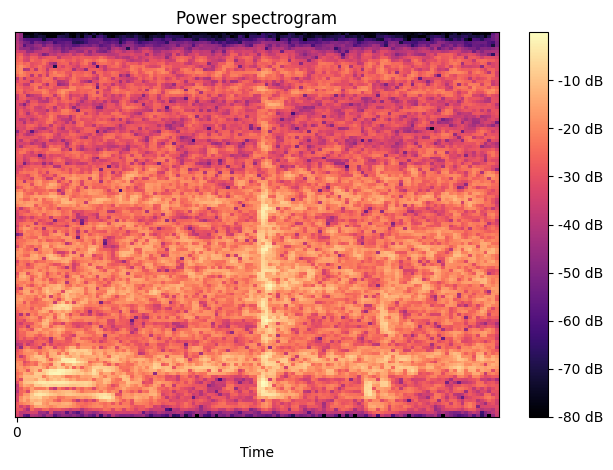

In [4]:
#### 3-1. 스펙트로그램 시각화 #############################################################################
import matplotlib.pyplot as plt
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [5]:
#### 4. 모든 데이터를 2차원 스펙트로그램으로 변경 ##############################################################
# with tf.device('/CPU:0'):
spec_data = np.asarray(list(wav2spec(data[i]) for i in range(len(data))))
label_data = label
print(spec_data.shape, label_data.shape)

(50620, 130, 126) (50620, 1)


### B. train/test 데이터셋 생성
  
* sklearn의 train_test_split 함수 이용 : train data와 test data 분리  
* test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정 가능

In [6]:
#### 5. 라벨 데이터 처리 ####################################################################################
## Text 형태의 라벨 데이터에 학습에 사용 가능한 index 부여
## unknown, silence는 구분되지 않는 데이터의 라벨
label_value = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i    
label_value = new_label_value
print('Indexed LABEL : ', new_label_value)
# {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [7]:
## label = speech_data["label_vals"]를 위에 생성해준 dict.. label_value에 해당하는 값으로 변경
## 예를들어 라벨이 yes였던 걸 0으로 바꿔주는 작업
temp = []
for v in label:
    temp.append(label_value[v[0]])
label_data = np.array(temp)
print(label_data.shape, label_data)
## array([ 3,  3,  3, ..., 11, 11, 11])

(50620,) [ 3  3  3 ... 11 11 11]


In [8]:
#### 4. 데이터 분리 ###################################################################################
from sklearn.model_selection import train_test_split

## spec 데이터를 source로 두고 분리, indexed label data를 타겟으로 두고
train_spec, test_spec, train_label, test_label = train_test_split(spec_data,
                                                                  label_data,
                                                                  test_size=0.1,
                                                                  shuffle=True)
print(train_spec.shape, test_spec.shape)                                                                  
train_spec = train_spec.reshape([-1,130,126,1]) # add channel for CNN
test_spec = test_spec.reshape([-1,130,126,1])
print("train data : ", train_spec.shape)
print("test data : ", test_spec.shape)

(45558, 130, 126) (5062, 130, 126)
train data :  (45558, 130, 126, 1)
test data :  (5062, 130, 126, 1)


* `tf.data.Dataset`을 이용하여 데이터셋 구성 (`Tensorflow`에 포함된 데이터셋 관리 패키지)  
* 위 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줌  
* `tf.data.Dataset.from_tensor_slices` 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용  
  
* map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할  
* 첫번째 map 함수는 `from_tensor_slice` 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정  
* map 함수는 중첩해서 사용 가능  
  
* 아래와 같이, map 함수에 넘겨줄 데이터 전처리 함수를 작성해보기

In [9]:
#### 5. 데이터셋 생성 ##################################################################################
## map : dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해줌
import tensorflow as tf

## 배치사이즈 커지면 메모리 사용량 증가, 경험상 학습에는 배치사이즈가 큰 영향 안 주는 듯
batch_size = 10

def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

with tf.device('/CPU:0'):   
    # for train
    ## 데이터를 [source, target] 쌍으로 엮어줌
    ## repeat(n) : n-interation per 1 ep., () means infinitely many
    ## #(data) / batch-size = n-interation(or n-step) per 1 ep.
    train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
    train_dataset = train_dataset.map(one_hot_label)
    train_dataset = train_dataset.repeat().batch(batch_size=batch_size)

    # for test
    test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
    test_dataset = test_dataset.map(one_hot_label)
    test_dataset = test_dataset.batch(batch_size=batch_size)

### C. Skip-connection Conv2D 모델 구현
  
* 2D 스펙토그램을 위한 Conv2D layer 사용
* 현재 라벨이 될 수 있는 12개의 단어 class 가지고 있음  
* 해당 class를 구분하기 위해 `multi-class classification` 필요  
* 이를 수행하기 위한 `Loss`로 `Categorical Cross-Entropy loss`를 사용할 것임

In [10]:
# #### 6-1. model construction ##############################################################################
# from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, Activation
# from keras import Model
# from keras.optimizers import Adam
# from keras.losses import CategoricalCrossentropy

# ## Conv1D는 Conv2D로, 9는 (3,3)으로 변경
# def spec_model(input_shape):
#     input_tensor = Input(shape=input_shape)  
#     x = Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)  
#     x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
#     x = MaxPool2D()(x)

#     x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
#     x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
#     x = MaxPool2D()(x)

#     x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
#     x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
#     x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
#     x = MaxPool2D()(x)

#     x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
#     x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
#     x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
#     x = MaxPool2D()(x)
#     x = Dropout(0.3)(x)

#     x = Flatten()(x)
#     x = Dense(256)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     output_tensor = Dense(12)(x)
#     model = Model(input_tensor, output_tensor)
#     opt = Adam(1e-4)  # 1e-4 : 0.0001
#     model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy'])
#     return model

In [11]:
#### 6-2. skip-conn. model construction #################################################################
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from keras import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

## Conv1D는 Conv2D로, 9는 (3,3)으로 변경
def spec_model(input_shape):
    input_tensor = Input(shape=input_shape)  
    x = Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)  #(None, 130, 126, 32)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x) #(None, 130, 126, 32)
    skip_1 = MaxPool2D()(x) #(None, 65, 63, 32)

    x = Conv2D(64, (3,3), padding='same', activation='relu')(skip_1) #(None, 65, 63, 64)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x) #(None, 65, 63, 64)
    x = tf.concat([x, skip_1], -1)
    skip_2 = MaxPool2D()(x)

    x = Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = tf.concat([x, skip_2], -1)
    skip_3 = MaxPool2D()(x)

    x = Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = tf.concat([x, skip_3], -1)
    x = MaxPool2D()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output_tensor = Dense(12)(x)
    model = Model(input_tensor, output_tensor)
    opt = Adam(1e-4)  # 1e-4 : 0.0001
    model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=['accuracy'])
    return model

* 모델 체크포인트 저장을 위한 체크포인트의 경로 설정  
* 후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올 때 사용
- Callback
  
    * `model.fit` 함수를 이용할 때, `callback` 함수를 이용하여 학습 중간 중간 원하는 동작을 하도록 설정 가능  
    * 모델을 재사용하기 위해 모델 가중치를 저장하는 `callback` 함수 추가  
    
    * `Model Checkpoint callback`은 모델을 학습을 진행하며, `fit` 함수 내 다양한 인자를 지정해 모니터하며 동작하게 설정 가능  
    * 현재 모델은 `validation loss`를 모니터하며, `loss`가 낮아지면 모델 파라미터를 저장하도록 구성되어 있음

In [12]:
#### 7. Model Checkpoint Callback #######################################################################
checkpt_dir = 'D:/geom/Aiffel/Fourier_signal/skip_spec_networks/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpt_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True, 
                                                 save_freq='epoch',
                                                 verbose=1)

### D. Training
* 메모리 사용량에 주의하며 적절히 하이퍼파라미터 세팅을 조절  
* 메모리가 부족하다면 batch_size를 작게 조절해 주는게 좋음

In [13]:
#### 8. model fit ##########################################################################################
## fit 함수는 학습결과를 리턴하고, 그 결과를 history_wav에 저장
input_shape = train_dataset.element_spec[0].shape[1:]
print(input_shape)
model = spec_model(input_shape)
history_wav = model.fit(train_dataset, epochs=10,
                    steps_per_epoch=len(train_spec) // batch_size, 
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

(130, 126, 1)
Epoch 1/10
4553/4555 [============================>.] - ETA: 0s - loss: 0.8046 - accuracy: 0.7418
Epoch 1: val_loss improved from inf to 0.30145, saving model to D:/geom/Aiffel/Fourier_signal/skip_spec_networks\
4555/4555 [==============================] - 87s 18ms/step - loss: 0.8043 - accuracy: 0.7419 - val_loss: 0.3014 - val_accuracy: 0.9059
Epoch 2/10
4553/4555 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.9097
Epoch 2: val_loss improved from 0.30145 to 0.21293, saving model to D:/geom/Aiffel/Fourier_signal/skip_spec_networks\
4555/4555 [==============================] - 83s 18ms/step - loss: 0.2963 - accuracy: 0.9097 - val_loss: 0.2129 - val_accuracy: 0.9306
Epoch 3/10
4553/4555 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9423
Epoch 3: val_loss improved from 0.21293 to 0.17429, saving model to D:/geom/Aiffel/Fourier_signal/skip_spec_networks\
4555/4555 [==============================] - 83s 18ms/step - loss: 0.188

### E. 학습 결과 시각화
- train_loss와 val_loss의 차이가 커진다면 overfitting일 수 있음
* `model.fit` 함수는 학습 동안의 결과를 return  
* return 값을 기반으로 loss와 accuracy를 그래프로 표현  
* `fit` 함수에서 전달 받은 Loss와 Accuracy의 값을 이용해 모델이 어떻게 학습되고 있는지 확인 가능  
* `train loss`와 `val_loss`의 차이가 커지는 경우 오버피팅이 일어나는 것이기 때문에 이를 수정할 필요가 있음  
* 출력된 그래프를 기반으로 모델의 학습이 어떻게 진행됐는지 확인

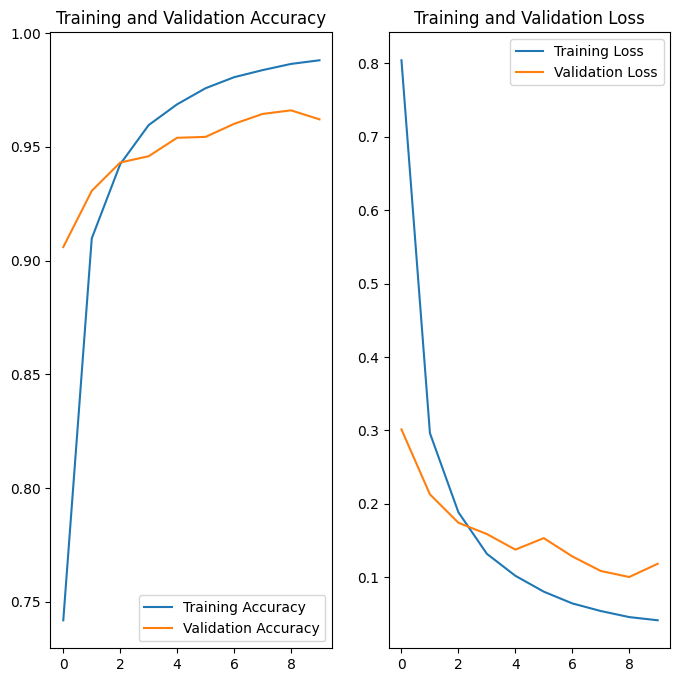

In [14]:
#### 9. accuracy, loss 비교 시각화 ###########################################################################
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### F. Evaluation
  
* Test dataset을 이용해서 모델의 성능 평가 : 모델의 예측값과 실제값이 얼마나 일치하는지 확인
* 실습삼아 `checkpoint callback` 함수가 저장한 weight를 다시 불러와서 테스트 준비

In [15]:
#### 10. accuracy, loss ####################################################################################
model.load_weights(checkpt_dir)
results = model.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

507/507 [==============================] - 3s 6ms/step - loss: 0.1007 - accuracy: 0.9660
loss value: 0.101
accuracy value: 96.6021%


### G. Model Test
* Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인

In [16]:
#### 11. Test data 셋을 골라 직접 들어보고 모델의 예측이 맞는지 확인 ######################################
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)
print(batch_index)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(16380,), rate=16380)

[789]
label :  down


In [17]:
#### 12. 테스트셋의 라벨과 모델의 실제 prediction 결과 비교 ###############################################
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + "(Correct!)")
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + "(Incorrect!)")

y_pred: right(Incorrect!)
